# CTSM fire refactor to allow FATES to use GDP data

This notebook attempts to determine if the raw GDP data available through ctsm is correctly being passed to FATES.  The code currently uses a [simple modified branch of FATES](https://github.com/glemieux/fates/tree/fire-gdp-simpletest) that assigns the `bc_in%gdp` variable to a standard site-level history output variable `FIRE_GDP`.  

## Setup notebook

In [1]:
import numpy as np
import xarray as xa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Import data

In [28]:
# gdp_lobata_col = xa.open_dataset('gdp_lf_col-test-brazil.fates.lobata.Cbaa65024-F17a71c48.clm2.h0.2000.nc')
gdp_chey_dir = xa.open_dataset('gdp-refactor-fatesoutcheck-init.fates-sci.1.49.0_api.17.0.0-ctsm5.1.dev061-C38e0f43a8-F17a71c48.gnu.clm2.h0.2000.nc')
gdp_chey_get = xa.open_dataset('gdp-refactor-fatesoutcheck-getgdpagain.fates-sci.1.49.0_api.17.0.0-ctsm5.1.dev061-C38e0f43a8-F2940ec0a.gnu.clm2.h0.2000.nc')
gdp_surdat_data = xa.open_dataset('surfdata_4x5_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc')

## Plot data comparisons

### Direct assignment versus `GetGDP` function

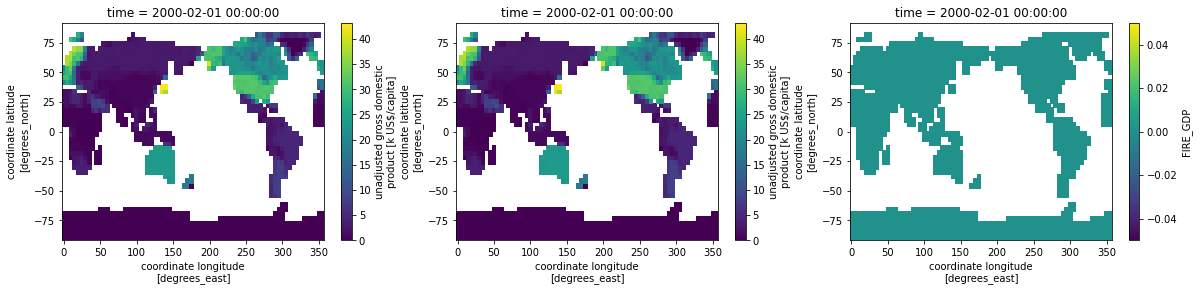

In [29]:
tidx = 0
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 4))
gdp_chey_dir.FIRE_GDP.isel(time=tidx).plot(ax=ax1)
gdp_chey_get.FIRE_GDP.isel(time=tidx).plot(ax=ax2)
(gdp_chey_dir.FIRE_GDP - gdp_chey_get.FIRE_GDP).isel(time=tidx).plot(ax=ax3)

The above plots verifies that the `GetGDP` function works

### Surface data set comparison to history output

In [21]:
# Rescale and assign the physical coordinates to do direct comparison to history output files
gdp_surdat_data = gdp_surdat_data.rename({'lsmlat':'lat','lsmlon':'lon'})
sdlon = gdp_surdat_data.lon * 5.0
sdlat = (gdp_surdat_data.lat * 4.0)-90.
gdp_surdat_data = gdp_surdat_data.assign_coords({'lat':sdlat,'lon':sdlon})

In [22]:
# Change all the locations with zero pct natveg to be nan by finding where division by zero gives inf (0/0 does not return inf)
nanveg = gdp_surdat_data.PCT_NATVEG.where(np.isinf(gdp_surdat_data.PCT_NATVEG/0.))

In [23]:
# Scale/mask the data
# gdp_surdat = gdp_surdat_data.gdp 
# gdp_surdat = gdp_surdat_data.gdp * (nanveg/100.) # Gridcells scaled by percent natveg
gdp_surdat = gdp_surdat_data.gdp * (nanveg/nanveg) # Only gridcells with natveg

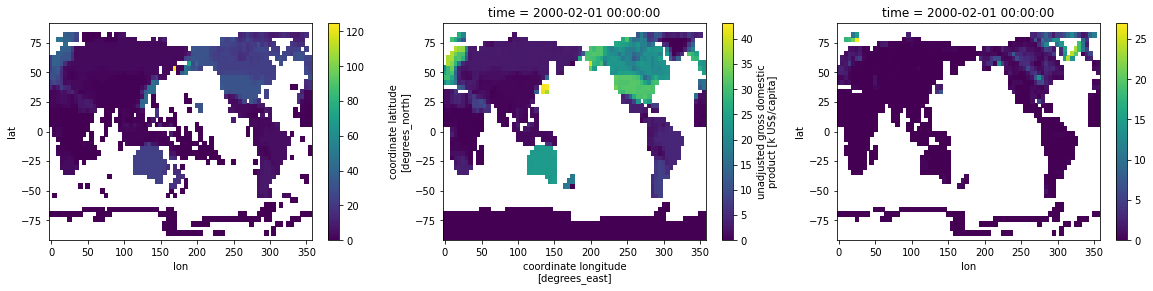

In [24]:
# Plot the difference
tidx = 0
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 4))
gdp_surdat.plot(ax=ax1)
gdp_chey_get.FIRE_GDP.isel(time=tidx).plot(ax=ax2)
(gdp_surdat - gdp_chey_get.FIRE_GDP.isel(time=0)).plot(ax=ax3)

The above plot seems to suggest that I'm not scaling or masking the data in the snowy areas correctly?  